# Mapeamento de vegetação, ervas daninha e solo, usando OpenCV

Link para o dataset:  https://drive.google.com/drive/folders/19HnvwosLbAoLhT5DvJyeatb1dB4JwtV6?usp=sharing

In [ ]:
!pip install opencv-python matplotlib numpy rasterio pandas geopandas seaborn shapely scikit-learn tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Libraries Import:

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.windows import Window
import pandas as pd
import geopandas as gpd
from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 18,16
from sklearn.model_selection import train_test_split
from rasterio.plot import show
from shapely.geometry import box
import seaborn as sns

Image and shapefiles that will be used is stored in Drive

In [ ]:
path_img = '/content/drive/MyDrive/Pinas/AOI_img.tif'
path_classe1 = '/content/drive/MyDrive/Pinas/Solo.shp'
path_classe2 = '/content/drive/MyDrive/Pinas/Veg.shp'
path_classe3 = '/content/drive/MyDrive/Pinas/Invasoras.shp'

In [ ]:
gdf1 = gpd.read_file(path_classe1)
gdf2 = gpd.read_file(path_classe2)
gdf3 = gpd.read_file(path_classe3)

<Axes: >

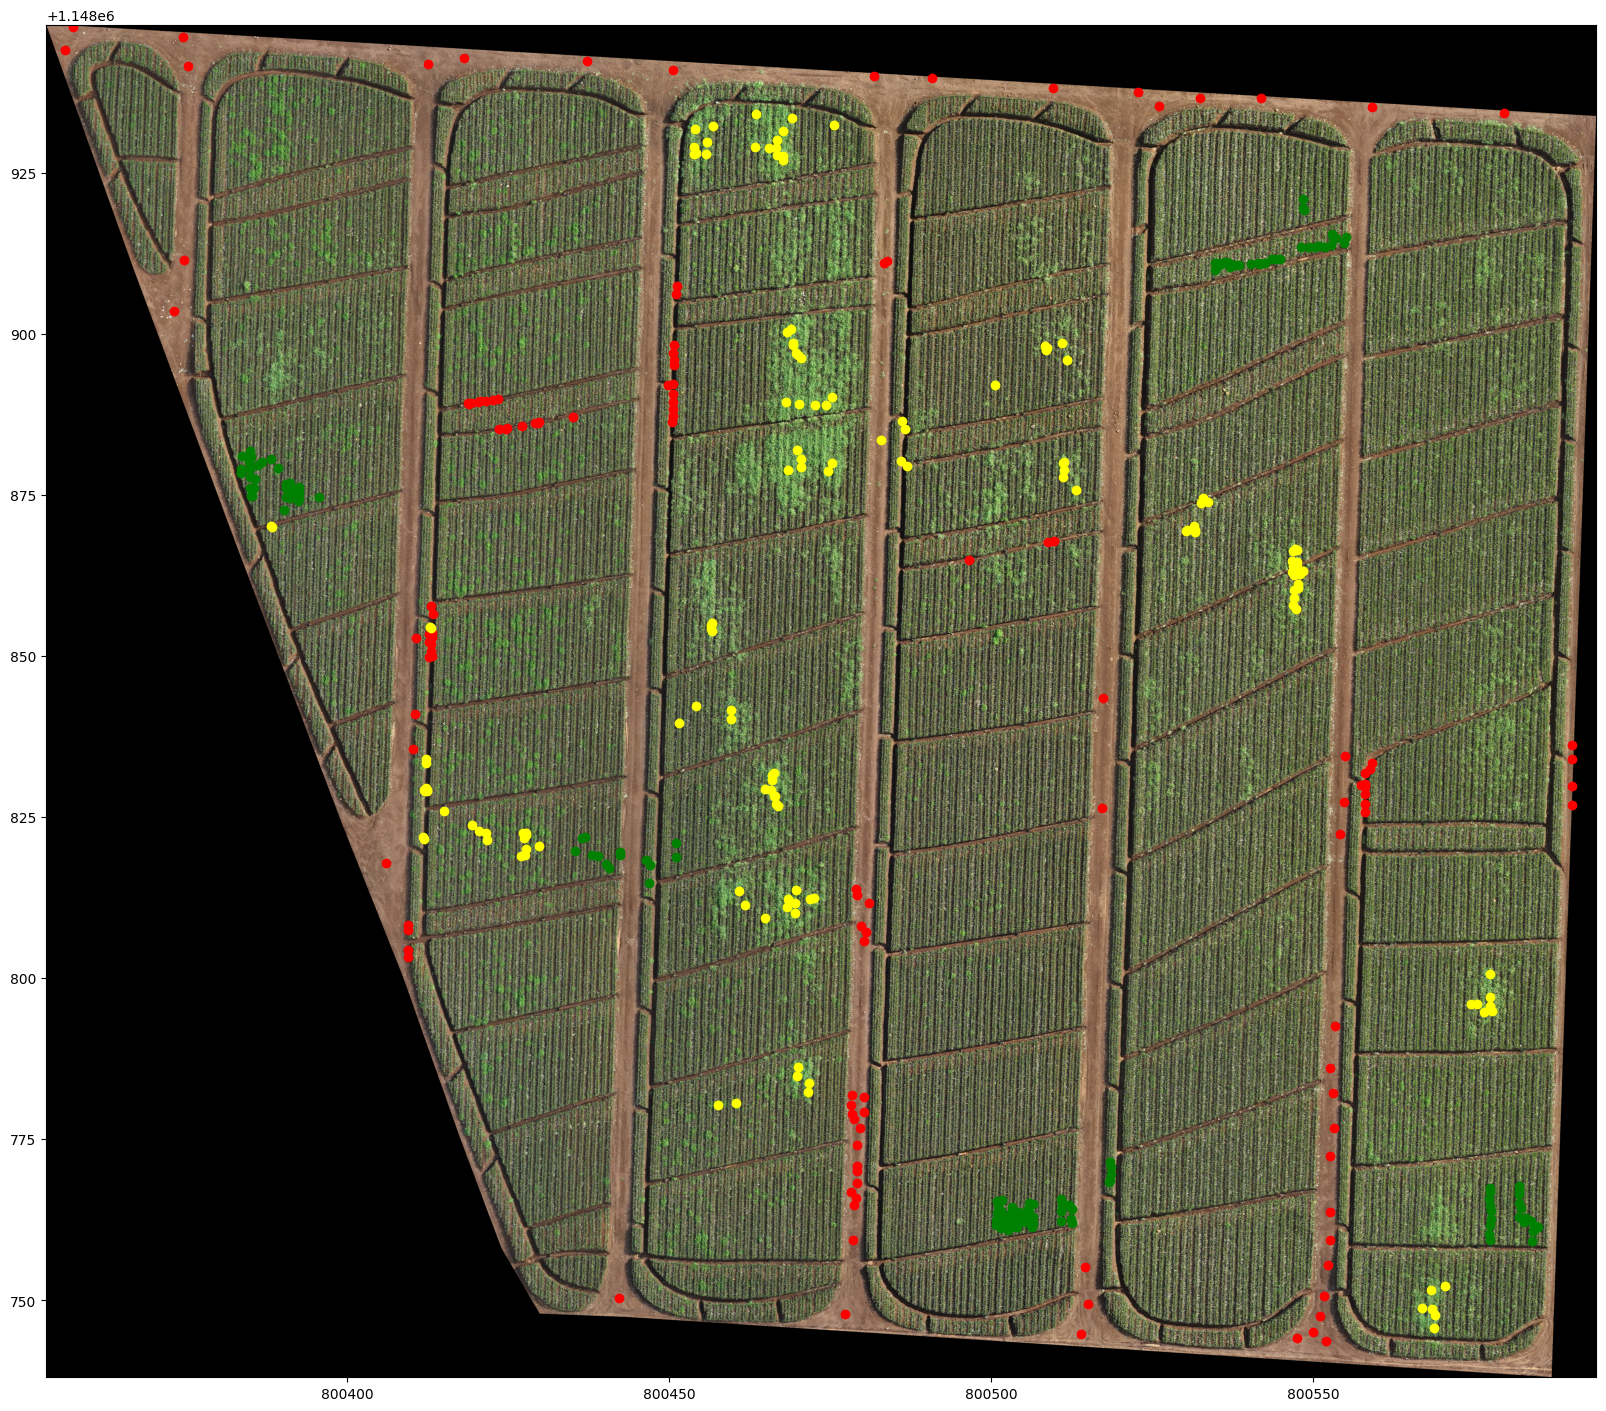

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
with rasterio.open(path_img) as src:
  gdf1 = gdf1.to_crs(src.crs.to_dict())
  gdf2 = gdf2.to_crs(src.crs.to_dict())
  gdf3 = gdf3.to_crs(src.crs.to_dict())
  show(src,ax=ax)
gdf1.plot(ax=ax, color='red')
gdf2.plot(ax=ax, color='green')
gdf3.plot(ax=ax, color='yellow')

Now we create an Id for each class

In [ ]:
gdf1['id'] = 0
gdf2['id'] = 1
gdf3['id'] = 2


Concatenating the GeoDataFrames and extracting spectral values for each point


In [ ]:
gdf = pd.concat([gdf1,gdf2,gdf3], axis = 0)

In [ ]:
gdf

id                        geometry
0     0  POINT (800522.754 1148937.597)
1     0  POINT (800541.974 1148936.659)
2     0  POINT (800559.084 1148935.253)
3     0  POINT (800579.593 1148934.315)
4     0  POINT (800509.628 1148938.182)
..   ..                             ...
147   2  POINT (800469.285 1148898.636)
148   2  POINT (800469.285 1148898.375)
149   2  POINT (800469.629 1148897.139)
150   2   POINT (800470.038 1148896.72)
151   2  POINT (800470.503 1148896.274)

[431 rows x 2 columns]

In [ ]:
coord_list = [(x,y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]

In [ ]:
Values_list = []
Column_list = []
with rasterio.open(path_img) as src:
  Values = [x for x in src.sample(coord_list)]
  Values_list.append(Values)

In [ ]:
X = np.array(Values_list)
X = X[0].copy()
X = X[:,0:3].copy()

Now we have X with the spectral data and Y with the reference data

In [ ]:
Y = gdf['id'].values
Y = Y[:,np.newaxis]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

Since the data is categorical, we need to encode it into binary values to match the neural network output


In [ ]:
enc = OneHotEncoder()

enc.fit(Y)

Y = enc.transform(Y).toarray()

In [ ]:
Y.shape

(431, 3)

Dividing the database into training and testing data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
input_shape = (X_train.shape[1:])
num_classes = len(np.unique(gdf['id'].values))

In [ ]:
input_shape

(3,)

In [ ]:
num_classes

3

Building the Neural Network

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Creating the NN with the dense layers

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,723 (166.89 KB)

 Trainable params: 42,723 (166.89 KB)

 Non-trainable params: 0 (0.00 B)

Training the model with 400 iterations

In [ ]:
history = model.fit(X_train, Y_train, epochs=400, batch_size=250, verbose=1, validation_split=0.25)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6222 - loss: 5.0500 - val_accuracy: 0.3026 - val_loss: 1.8378
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2489 - loss: 2.0896 - val_accuracy: 0.3816 - val_loss: 3.8831
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3733 - loss: 4.2894 - val_accuracy: 0.4079 - val_loss: 1.7819
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4267 - loss: 1.8480 - val_accuracy: 0.3158 - val_loss: 1.7468
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3778 - loss: 1.5633 - val_accuracy: 0.3158 - val_loss: 2.4925
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3778 - loss: 2.2511 - val_accuracy: 0.3158 - val_loss: 1.8993
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3778 - loss: 1.7266 - val_accuracy: 0.7368 - val_loss: 0.8569
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7067 - loss: 0.8017 - val_accuracy: 0.4868 - val_loss: 0

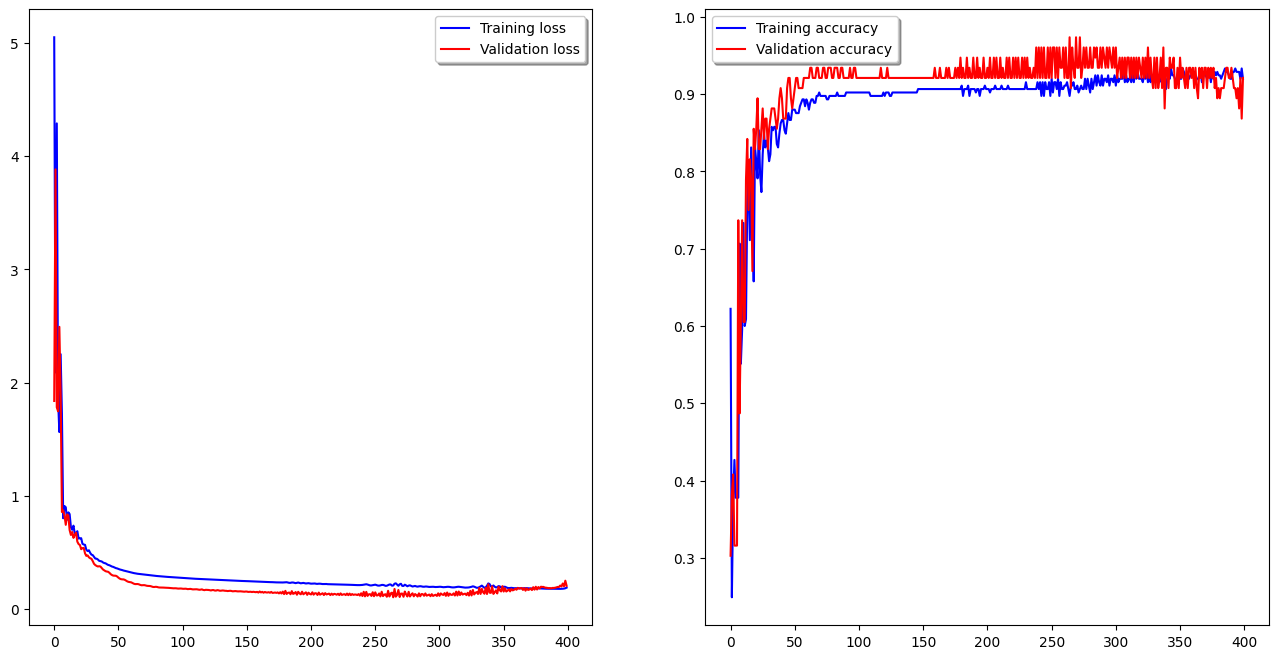

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2504327595233917
Test accuracy: 0.8999999761581421


In [ ]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:
y_pred_res = np.argmax(y_pred, axis=1)

In [ ]:
Y_test_res = np.argmax(Y_test, axis=1)

In [ ]:
print(classification_report(Y_test_res, y_pred_res))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        49
           1       0.79      0.89      0.84        38
           2       0.90      0.81      0.85        43

    accuracy                           0.90       130
   macro avg       0.90      0.90      0.89       130
weighted avg       0.90      0.90      0.90       130



In [ ]:
c_matrix = confusion_matrix(Y_test_res, y_pred_res)

In [ ]:
names = ['Solo', 'Vegetação', 'Daninhas']

Text(0.5, 58.7222222222222, 'Predict')

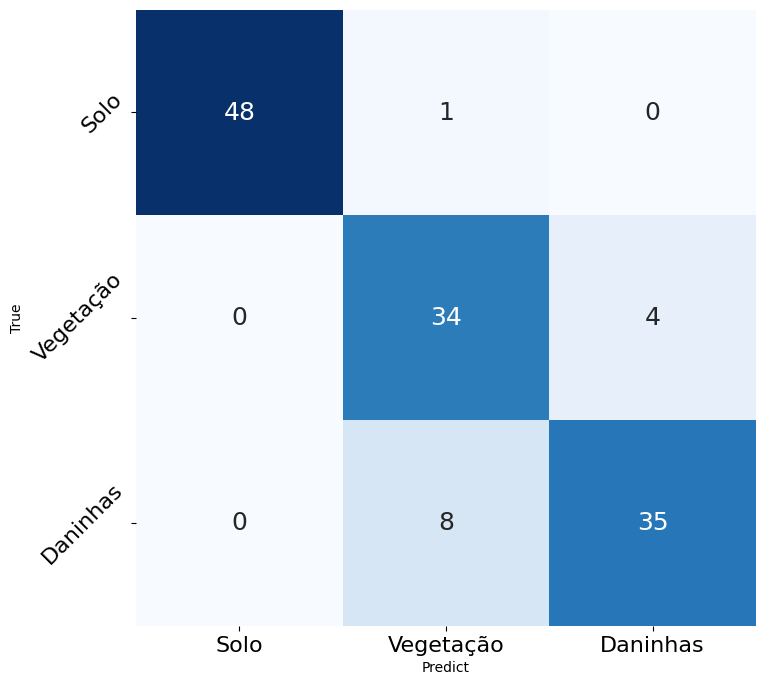

In [ ]:
r1 = pd.DataFrame(data = c_matrix, index = names, columns = names)
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(r1, annot=True, annot_kws={"size": 18}, fmt='d', cmap="Blues", cbar = False)
ax.tick_params(labelsize=16)
ax.set_yticklabels(names, rotation = 45)
ax.set_ylabel('True')
ax.set_xlabel('Predict')

Generating the prediction map by applying the trained model to the image

In [ ]:
src = rasterio.open(path_img)
img = src.read()

In [ ]:
img = img.transpose([1,2,0])
img_size = (img.shape[0], img.shape[1])
img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

In [ ]:
img.shape

(51650802, 4)

After opening the image, we will create a dataframe with spectral information and the alpha band

In [ ]:
df = pd.DataFrame(img, columns=['R','G','B','Mask'])

In [ ]:
del img, src

Removing the non-valid values using alpha band

In [ ]:
df_to_pred = df[df['Mask'] == 255].copy()
values_to_pred = df_to_pred.values[:,0:3]

In [ ]:
df_to_pred.drop(columns={'R','G','B'}, inplace = True)
df.drop(columns={'R','G','B'}, inplace = True)

Applying the model

In [ ]:
pred = model.predict(values_to_pred)

1251127/1251127 ━━━━━━━━━━━━━━━━━━━━ 663s 530us/step


With the values, we join them to the full image dataframe using the index:

In [ ]:
pred = np.argmax(pred, axis = 1).copy()
df_to_pred['pred'] = pred

In [ ]:
del pred, values_to_pred, model

In [ ]:
df = pd.merge(df,df_to_pred, how='left', left_index = True, right_index = True)

In [ ]:
del df_to_pred

In [ ]:
values_to_export = df['pred'].values

In [ ]:
del df

In [ ]:
classify = values_to_export.reshape(img_size)
export_image = classify[np.newaxis,:,:]

Saving the predict image data with the geo refference of the RGB image

In [ ]:
src = rasterio.open(path_img)
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": export_image.shape[1],
                  "width": export_image.shape[2],
                  "compress":'lzw',
                  "nodata": np.nan,
                  "dtype": 'float64',
                  "count":1
                  })

In [ ]:
with rasterio.open('/content/mapa.tif', "w", **out_meta) as dest:
     dest.write(export_image)

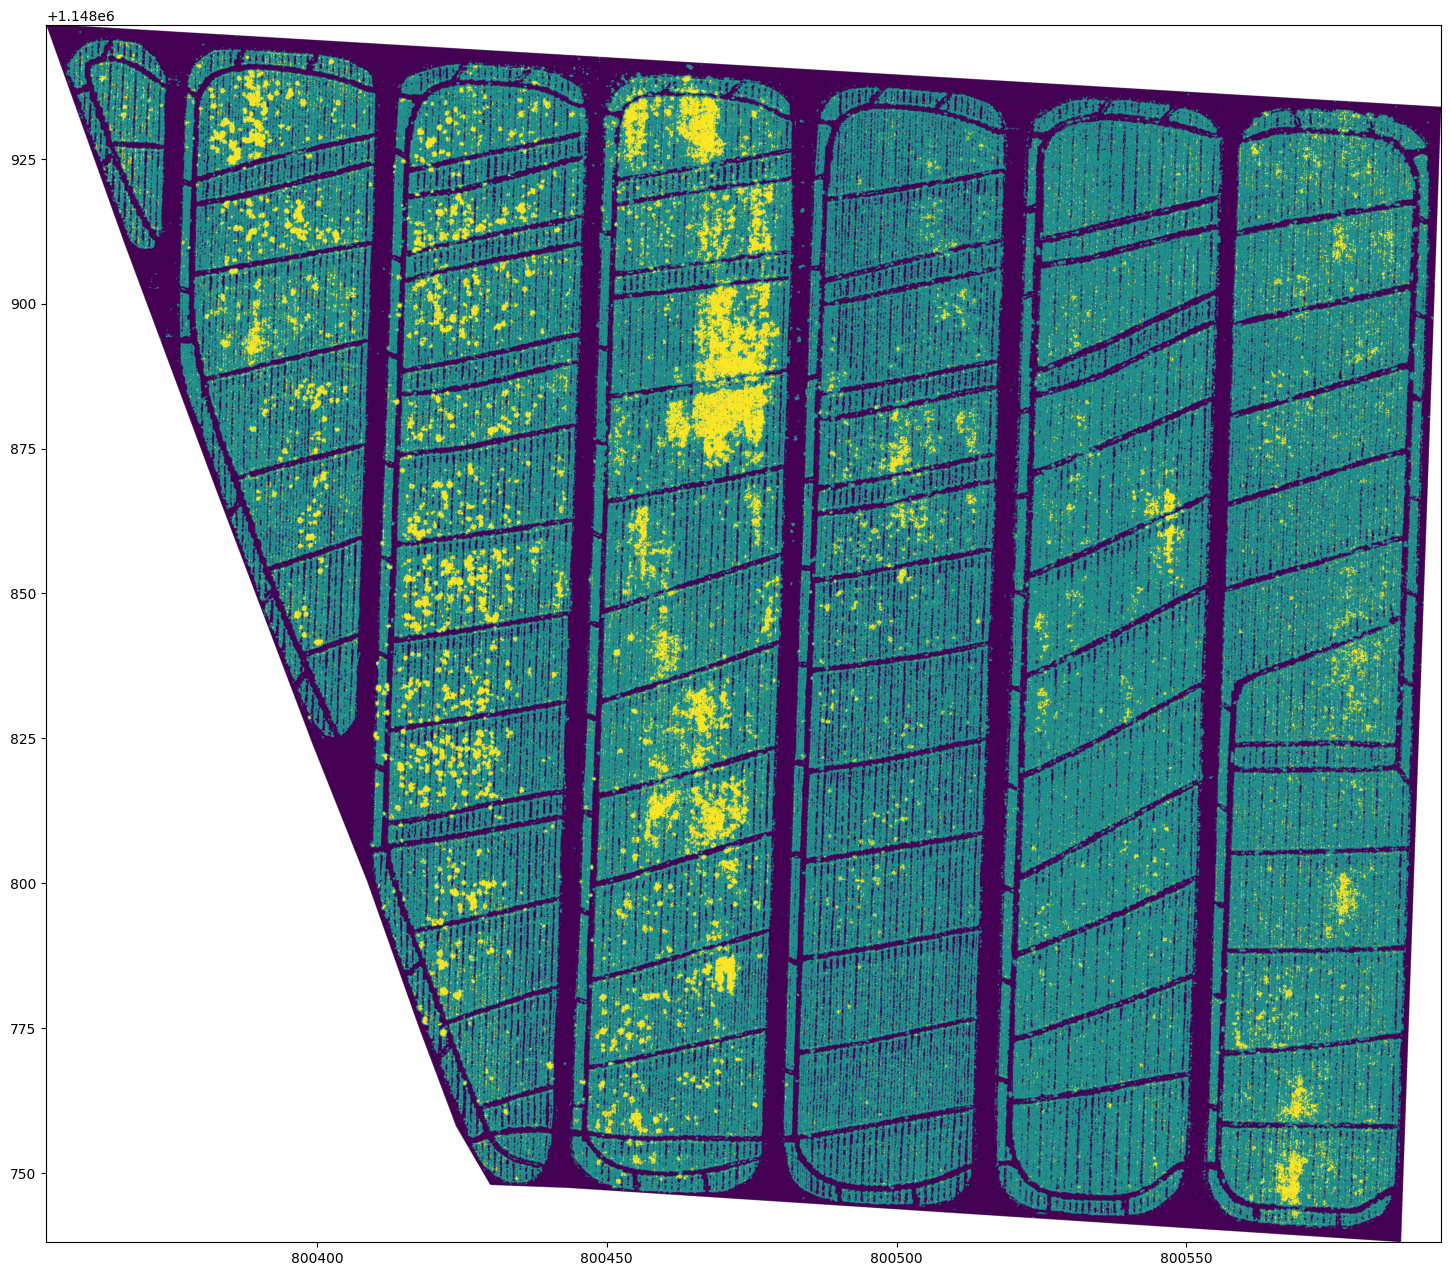

In [116]:
with rasterio.open('/content/mapa.tif') as src:
    show(src)